# Predator-Prey Simulation
The code below runs a simulation of a predator-prey relationship.<br>
A number of parameters can be adjusted below to explore their effect on the relationship.

### How to use the simulation
This page (known as a Jupyter Notebook) is set up as a series of 'cells'.<br>
Each cell needs to be run in turn. You can then edit and rerun any cells as required.

## Select Cell > Run All from the menubar at the top. This will run all of the cells to perform the initial set up

### You can rerun individual cells by selecting them and pressing Ctrl + Enter

##### Details:
Language: Python 3<br>
Date: 27/7/19<br>
Author: Dr A White, Seton Catholic College

### The Code
Below is the code that executes the simulation.
DO NOT TOUCH THIS CODE OR YOU WILL BREAK IT! (Unless you know what you're doing).

### Keep scrolling down to edit and rerun the simulation

In [230]:
import random
import time
import math
import matplotlib.pyplot as plt
%matplotlib inline
   

class predator_prey(object):
    """The class to handle simulator parameters, grid coordinates,
       and stepping through predator-prey generations.
       
       Parameters:
           prey: the starting number of prey
           predators: the starting number of predators
           dim: 1D hexagonal grid size
           breed_factor: Factor by which the surviving prey population increases
           kill_factor: Number of additional neighbouring prey killed
                        following a direct kill
    """
    
    def __init__(self, prey=6, predators=1, dim=5, breed_factor=2, kill_factor=2):
        "Initialise the class"
        
        # Check parameters are within acceptable bounds
        self.dim = check_parameters(dim, [2, 10])
        self.breed_factor = check_parameters(breed_factor, [1, 4])
        self.kill_factor = check_parameters(kill_factor, [0, 6])
        
        self.predator_gens = [check_parameters(predators, [1, self.max_loc])]
        self.prey_gens = [check_parameters(prey, [2, self.max_loc])]
        
        # Define empty coordinate sets
        self.prey_coords = set()
        self.predator_coords = set()
    
    
    def reset(self):
        "Reset the predator-prey generations to the starting numbers"
        self.predator_gens = self.predator_gens[0:1]
        self.prey_gens = self.prey_gens[0:1]

    
    def distribute(self, num):
        """Generate a random set of hexagonal grid coordinates.
           Chooses the smallest number to either include
           or exclude from all possible coordinates.
           Uses hexagonal 'cubic' coordinate system as described here:
           https://www.redblobgames.com/grids/hexagons/
           
           Parameters:
               num: the total number of coordinates that need to be distributed
        """
        # Determine whether to search for included or excluded coordinates
        search_num = min([num, self.max_loc - num])
        
        coords = set()
        while len(coords) < search_num:
            coords.add(get_coord(self.dim))
            
        if self.max_loc - num < self.max_loc/2:
            return self.all_coords 
        else:
            return coords
        
        
    @property
    def max_loc(self):
        "Return the maximum number of grid coordinates"
        loc = [i for i in range(self.dim, 2*self.dim)]
        loc += loc[:-1]
        return sum(loc)
    
    @property
    def prey(self):
        "Return the number of prey in the current generation"
        return self.prey_gens[-1]
    
    
    @property
    def predators(self):
        "Return the number of predators in the current generation"
        return self.predator_gens[-1]
    
    
    @property
    def all_coords(self):
        "Return a set of all possible grid coordinates"
        all_coords = set()
        for x in range(self.dim):
            for y in range(1-self.dim, self.dim-x):
                all_coords.add((x, y, -(y+x)))
                all_coords.add((-x, -y, y+x))
        
        return all_coords
    
    
    def step(self):
        "Run the simulator for one generation."
        
        # Distribute predators and prey
        self.prey_coords = self.distribute(self.prey)
        self.predator_coords = self.distribute(self.predators)
        
        # Find direct kills
        direct_kills = self.predator_coords & self.prey_coords
        
        # Find kills in in coordinates neighbouring direct kills
        all_neighbour_kills = {}
        for coord in direct_kills:
            kill_set = (get_neighbours(coord) & self.prey_coords) - direct_kills
            if len(kill_set) > 0:
                all_neighbour_kills[coord] = [kill_set, len(kill_set)]
        
        # Determine unique neighbour kills - i.e. one prey can't be killed twice
        neighbour_kill_coords = set()
        kills_w_neighbours = set()
        
        for i in range(1,7):
            for coord in all_neighbour_kills.keys():
                if all_neighbour_kills[coord][1] == i:
                    kill_set = all_neighbour_kills[coord][0] - neighbour_kill_coords
                    if 0 < len(kill_set) <= self.kill_factor:
                        neighbour_kill_coords = neighbour_kill_coords | kill_set
                    else:
                        # THIS NEEDS FIXING - doesn't maximise number of neighbour kills"
                        neighbour_kill_coords = neighbour_kill_coords | set(list(kill_set)[:self.kill_factor])
                    
                    kills_w_neighbours.add(coord)
                    
        # Get new predator-prey populations
        total_kills = len(direct_kills) + len(neighbour_kill_coords)
        
        new_prey_pop = round(self.breed_factor*(self.prey_gens[-1] - total_kills))
        new_predator_pop = round((self.predator_gens[-1] - (self.predators - len(direct_kills))) + (len(kills_w_neighbours)))
        
        self.prey_gens += [check_parameters(new_prey_pop, [1, self.max_loc])]
        self.predator_gens += [check_parameters(new_predator_pop, [1, self.max_loc])]
        

def check_parameters(param, defaults):
    """Check parameters are within acceptable bounds.
    
       Parameters:
           param: the parameter to check
           defaults: list in form [minimum, maximum]
    """
    if param < defaults[0]:
        return defaults[0]
    elif param > defaults[1]:
        return defaults[1]
    else:
        return param

    
def get_coord(dim):  
    """Randomly generate a single coordinate on the hexagonal grid.
    
       Parameters:
           dim: 1D hexagonal grid size
    """
    x = random.randrange(dim)
    y = random.randrange(1-dim, dim-x)
    z = -(y+x)

    sign = 1 if random.random() < 0 else -1

    return (x*sign, y*sign, z*sign)
        
        
def get_neighbours(coord):
    """Generate coordinates of neighbouring cells around a given coordinate.
       
       Parameters:
           coord: The cooridnate around which to find neighbours
    """
    return set([(coord[0], coord[1]+1, coord[2]-1),
                (coord[0], coord[1]-1, coord[2]+1),
                (coord[0]+1, coord[1], coord[2]-1),
                (coord[0]-1, coord[1], coord[2]+1),
                (coord[0]+1, coord[1]-1, coord[2]),
                (coord[0]-1, coord[1]+1, coord[2])])
        
        
def plot(pp):
    """Create a plot showing the current positions of prey and predators
       and the predator-prey populations for each generation.
       
       Parameters:
           pp: a predator-prey class instance
    """
    # create figure
    fig, ax = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={'height_ratios': [2, 1]});

    # Vectors to convert hexagonal coordinates to cartesian
    x_vector = [0.5, math.sqrt(3)/2]
    y_vector = [-0.5, math.sqrt(3)/2]
    z_vector = [0, -math.sqrt(3)/2]

    colors = ['r', 'b']
    legend_labels = ['predators', 'prey']
    
    # Plot predator-prey locations
    for ind, k in enumerate([pp.predator_coords, pp.prey_coords]):
        x = [(i[0] * x_vector[0]) + (i[1] * y_vector[0]) + (i[2] * z_vector[0]) for i in k]
        y = [(i[0] * x_vector[1]) + (i[1] * y_vector[1]) + (i[2] * z_vector[1]) for i in k]

        ax[0].plot(x, y, 'o', color=colors[ind], ms=8/(ind+1), label=legend_labels[ind]);
    
    lim = max([abs(i) for i in ax[0].get_ylim() + ax[0].get_xlim()])
    ax[0].set_ylim([-lim, lim])
    ax[0].set_xlim([-lim, lim])
    ax[0].get_xaxis().set_visible(False)
    ax[0].get_yaxis().set_visible(False)
    ax[0].legend()    
    
    # Plot populations over time
    for ind, k in enumerate([pp.predator_gens[:-1], pp.prey_gens[:-1]]):
        x = [i for i in range(1,len(k)+1)]
        ax[1].plot(x, k, 'o-', color=colors[ind])
    
    ax[1].set_ylabel('Population size')
    ax[1].set_xlabel('Generation number')

## Simulator
Here is where you can run the simulation.

First, set up your parameters in the cells below:

### Parameters
The simulator uses a hexagonal grid. **Choose a number between 5 - 10** to set the size of the grid.

When you have changed the number, rerun the cell by pressing Ctrl + Enter.

In [262]:
grid_size = 8

Change the numbers below to set the starting number of prey and predator animals. **Choose sensible numbers. Extreme numbers will automatically be reset to the defaults.**

When you have changed the numbers, rerun the cell by pressing Ctrl + Enter

In [265]:
starting_number_of_prey = 6
starting_number_of_predators = 1

Change the number below to set how rapidly the prey reproduce.

2 means that the surviving prey population will double.

**Choose a sensible number between 1 - 4. Extreme numbers will automatically be reset to the defaults.**

When you have changed the number, rerun the cell by pressing Ctrl + Enter.

In [261]:
breeding_rate = 1.5

Change the number below to set how how many extra prey predators can kill.

2 means that a predator that makes a kill can also kill and extra 2 nearby prey.

**Choose a sensible number between 0 - 6. Extreme numbers will automatically be reset to the defaults.**

When you have changed the number, rerun the cell by pressing Ctrl + Enter.

In [38]:
predator_kill_rate = 2

### Rerun the cell below if you change any parameters as this will reset the simulator

Run the cell by pressing Ctrl + Enter.

In [283]:
pp = predator_prey(
    prey=starting_number_of_prey,
    predators=starting_number_of_predators,
    dim=grid_size,
    breed_factor=breeding_rate,
    kill_factor=predator_kill_rate)

### Run the cell below as many times as you like to step through sequential generations of predators and prey.
Run the cell by pressing Ctrl + Enter

set()


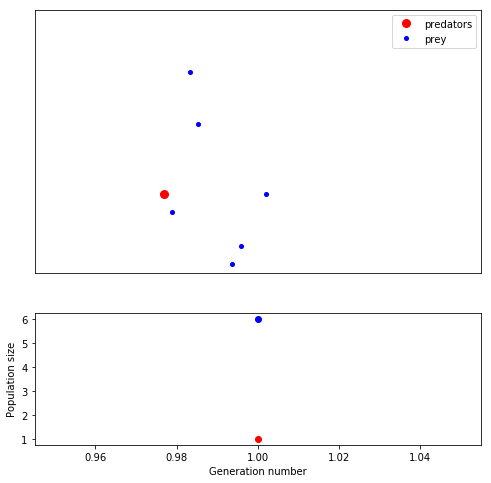

In [284]:
pp.step()
plot(pp)